In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=1bcddf9ae92de1151da579c8f7b60b54b975c9e5bd8451490c2fdb6dfae8f5c7
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import *

In [ ]:
# Install Prophet
!pip install Prophet

In [ ]:
from prophet import Prophet

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .appName("Colab")\
        .getOrCreate()

In [ ]:
spark


In [ ]:

df  = spark.read.csv("SM Cleaned Data BR Aggregated.csv", header=True, inferSchema=True)


In [ ]:
historical_data  = spark.read.csv("SM Cleaned Data BR Aggregated.csv", header=True, inferSchema=True)


In [ ]:
df.show()

+-----+----------+------------------+
|meter|      Date|             t_kWh|
+-----+----------+------------------+
| BR02|2019-07-10| 6.959999999999997|
| BR02|2019-07-11| 4.910999999999991|
| BR02|2019-07-13| 5.872999999999988|
| BR02|2019-07-14| 5.457999999999984|
| BR02|2019-07-15| 4.859999999999995|
| BR02|2019-07-16| 4.281999999999985|
| BR02|2019-07-17| 4.421999999999985|
| BR02|2019-07-18|  4.33699999999998|
| BR02|2019-07-19| 5.441999999999984|
| BR02|2019-07-20| 5.650999999999988|
| BR02|2019-07-30| 5.847999999999994|
| BR02|2019-07-31|5.8319999999999865|
| BR02|2019-08-01| 5.006999999999988|
| BR02|2019-08-04| 7.383999999999983|
| BR02|2019-08-05| 6.977999999999994|
| BR02|2019-08-06|5.2839999999999945|
| BR02|2019-08-07| 5.651999999999995|
| BR02|2019-08-08|4.7749999999999835|
| BR02|2019-08-09| 5.005999999999984|
| BR02|2019-08-10|5.8899999999999775|
+-----+----------+------------------+
only showing top 20 rows



In [ ]:
df = df.na.drop()
import pyspark.sql.functions as F

In [ ]:
df.count()

28119

In [ ]:
# Group the data by "Date" and calculate the average for each date
consolidated_df = df.groupBy("Date").agg(F.avg("t_kWh").alias("Avg_t_kWh"))
# Sort the consolidated data by the "Date" column
consolidated_df = consolidated_df.orderBy("Date")

# Show the consolidated data
consolidated_df.show()

+----------+------------------+
|      Date|         Avg_t_kWh|
+----------+------------------+
|2019-05-09|11.043999999999995|
|2019-05-10|11.929999999999982|
|2019-05-11|14.496000000000006|
|2019-05-12|14.276999999999974|
|2019-05-13|10.201000000000011|
|2019-05-14|11.803999999999984|
|2019-05-15|11.655999999999967|
|2019-05-16| 9.922999999999972|
|2019-05-17|11.123999999999997|
|2019-05-18|11.318999999999967|
|2019-05-19|12.457999999999977|
|2019-05-20|11.927999999999955|
|2019-05-21| 12.35099999999999|
|2019-05-22| 13.05399999999996|
|2019-05-23|11.467000000000004|
|2019-05-26| 9.435999999999988|
|2019-05-27| 10.98599999999998|
|2019-05-28|11.150999999999984|
|2019-05-29| 12.21899999999998|
|2019-05-30| 20.97500000000002|
+----------+------------------+
only showing top 20 rows



In [ ]:
consolidated_df.count()

885

In [ ]:
consolidated_df.printSchema()


root
 |-- Date: date (nullable = true)
 |-- Avg_t_kWh: double (nullable = true)



In [ ]:
consolidated_df.describe().show()

+-------+------------------+
|summary|         Avg_t_kWh|
+-------+------------------+
|  count|               885|
|   mean| 8.694627556704477|
| stddev|3.3451380940390743|
|    min|3.7017857142857067|
|    max| 21.91799999999997|
+-------+------------------+



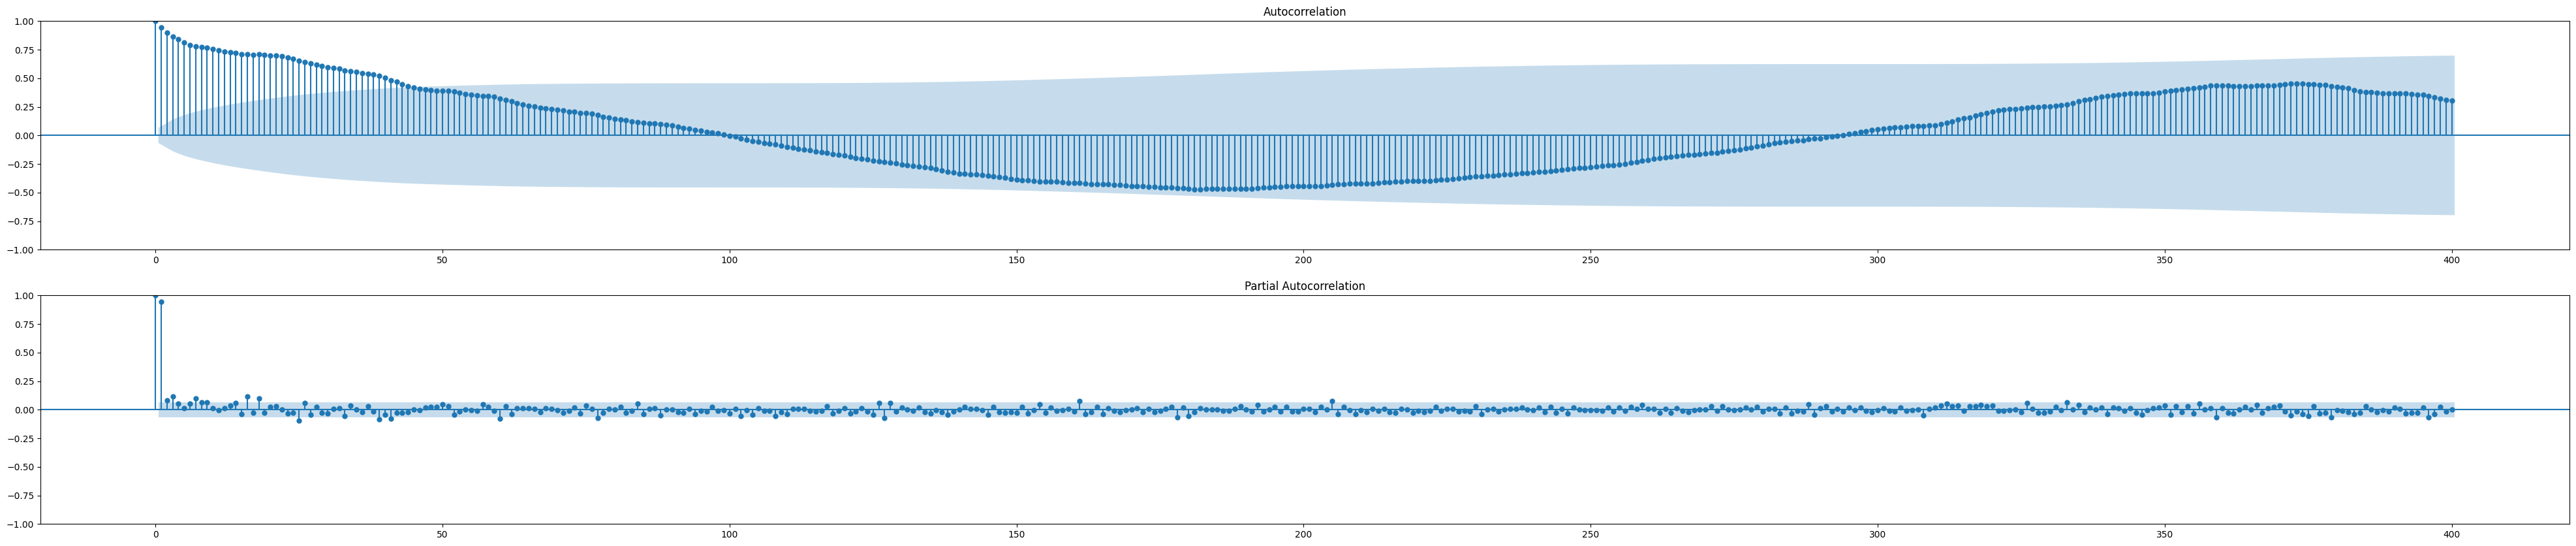

In [ ]:

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Convert the consolidated and sorted DataFrame to a Pandas DataFrame
pandas_df = consolidated_df.toPandas()

# Extract 'Date' and 'Avg_t_kWh' columns as a time series
date_series = pd.to_datetime(pandas_df['Date'])
t_kWh_series = pandas_df['Avg_t_kWh']

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(50, 10))
acf_plot = plot_acf(t_kWh_series, ax=ax1, lags=400)
pacf_plot = plot_pacf(t_kWh_series, ax=ax2, lags=400)

plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Extract 'Avg_t_kWh' as a time series
t_kWh_series = pandas_df['Avg_t_kWh']

# Perform the Augmented Dickey-Fuller test
result = adfuller(t_kWh_series)

# Print the ADF test results
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f"ADF Statistic: {adf_statistic}")
print(f"P-Value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")

# Check for stationarity based on the ADF test
if p_value <= 0.05:
    print("The time series is likely stationary.")
else:
    print("The time series is likely non-stationary.")


ADF Statistic: -2.0388881548564126
P-Value: 0.26978647807030176
Critical Values:
  1%: -3.437914898140353
  5%: -2.864879373440662
  10%: -2.5685481313814624
The time series is likely non-stationary.


In [ ]:
t_kWh_series.head()

0    11.044
1    11.930
2    14.496
3    14.277
4    10.201
Name: Avg_t_kWh, dtype: float64

In [ ]:


# Perform differencing to make the time series stationary
differenced_series = t_kWh_series.diff().dropna()  # 1st order differencing

# Perform the Augmented Dickey-Fuller test on the differenced series
adf_result = adfuller(differenced_series)

# Print the ADF test results for the differenced series
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

print("Differenced Series ADF Test Results:")
print(f"ADF Statistic: {adf_statistic}")
print(f"P-Value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")

# Check for stationarity based on the ADF test
if p_value <= 0.05:
    print("The differenced series is stationary.")

else:
    print("The differenced series is likely non-stationary.")

Differenced Series ADF Test Results:
ADF Statistic: -10.317006704967888
P-Value: 3.0785148508656816e-18
Critical Values:
  1%: -3.437914898140353
  5%: -2.864879373440662
  10%: -2.5685481313814624
The differenced series is stationary.


In [ ]:
differenced_series.head()

1    0.886
2    2.566
3   -0.219
4   -4.076
5    1.603
Name: Avg_t_kWh, dtype: float64

In [ ]:
pandas_df.head()

,Date,Avg_t_kWh
0,2019-05-09,11.044
1,2019-05-10,11.930
2,2019-05-11,14.496
3,2019-05-12,14.277
4,2019-05-13,10.201


In [ ]:
from pyspark.sql.functions import year, month, dayofweek

# Extract year, month, and day of the week as features
consolidated_df = consolidated_df.withColumn("Year", year("Date"))
consolidated_df = consolidated_df.withColumn("Month", month("Date"))
consolidated_df = consolidated_df.withColumn("DayOfWeek", dayofweek("Date"))

# Show the DataFrame with added time-based features
consolidated_df.show()


+----------+------------------+----+-----+---------+
|      Date|         Avg_t_kWh|Year|Month|DayOfWeek|
+----------+------------------+----+-----+---------+
|2019-05-09|11.043999999999995|2019|    5|        5|
|2019-05-10|11.929999999999982|2019|    5|        6|
|2019-05-11|14.496000000000006|2019|    5|        7|
|2019-05-12|14.276999999999974|2019|    5|        1|
|2019-05-13|10.201000000000011|2019|    5|        2|
|2019-05-14|11.803999999999984|2019|    5|        3|
|2019-05-15|11.655999999999967|2019|    5|        4|
|2019-05-16| 9.922999999999972|2019|    5|        5|
|2019-05-17|11.123999999999997|2019|    5|        6|
|2019-05-18|11.318999999999967|2019|    5|        7|
|2019-05-19|12.457999999999977|2019|    5|        1|
|2019-05-20|11.927999999999955|2019|    5|        2|
|2019-05-21| 12.35099999999999|2019|    5|        3|
|2019-05-22| 13.05399999999996|2019|    5|        4|
|2019-05-23|11.467000000000004|2019|    5|        5|
|2019-05-26| 9.435999999999988|2019|    5|    

In [ ]:
# Convert the Spark DataFrame to a Pandas DataFrame
historical_pd = consolidated_df.toPandas()

# Set the Date column as the index
historical_pd['Date'] = pd.to_datetime(historical_pd['Date'])
historical_pd.set_index("Date", inplace=True)

# Extract the target variable
t_kWh = historical_pd['Avg_t_kWh']

In [ ]:
def test_stationarity(timeseries):
    # Perform the ADF test
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Check stationarity of the target variable
test_stationarity(t_kWh)

ADF Statistic: -2.0388881548564126
p-value: 0.26978647807030176
Critical Values:
   1%: -3.437914898140353
   5%: -2.864879373440662
   10%: -2.5685481313814624


NON-STATIONARY IT IS

In [ ]:

from pyspark.sql.functions import year, month, avg
from pyspark.sql.types import DateType
from pyspark.sql.functions import to_date

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql import Window
from tkinter import *

In [ ]:
class LagGather:
# generates features for machine-learning
# previous time-step values are used as features
  def __init__(self):
    # this class has 2 data members
    self.nLags = 0
    self.FeatureNames = []
  def setLagLength(self, nLags):
    # this method sets the lag-length
    # if we want only previous time-step as feature
    # use lag-length = 1
    # if we want more lagged time-steps as features
    # set higher lag-length
    self.nLags = nLags
    return self
  def setInputCol(self, colname):
    #sets the input col for which features are generated
    # this identifies the univariate time-series on
    # which machine-learning and forecasting is done
    self.columnName = colname
    return self
  def transform(self, df):
    # transforms the spark dataframe and creates columns
    # that have time-lagged values
    # columns generated as used as features in ML
    df = df.withColumn("Series",lit('Univariate'))
    mywindow = Window.orderBy("Series")
    for i in range(self.nLags):
        strLag = self.columnName+'_LagBy_'+str(i+1)
        df = df.withColumn(strLag,lag(\
                          df[self.columnName], i+1).over(mywindow))
        self.FeatureNames.append(strLag)
    df = df.drop("Series")
    return df
  def getFeatureNames(self):
    # this return the names of feature-columns that are
    # generated by transform method
    return self.FeatureNames

In [ ]:
lg=LagGather().setInputCol("Avg_t_kWh").setLagLength(1)
transformed=lg.transform(consolidated_df)
print(transformed.head())
print(transformed.show())

Row(Date=datetime.date(2019, 5, 9), Avg_t_kWh=11.043999999999995, Year=2019, Month=5, DayOfWeek=5, Avg_t_kWh_LagBy_1=None)
+----------+------------------+----+-----+---------+------------------+
|      Date|         Avg_t_kWh|Year|Month|DayOfWeek| Avg_t_kWh_LagBy_1|
+----------+------------------+----+-----+---------+------------------+
|2019-05-09|11.043999999999995|2019|    5|        5|              NULL|
|2019-05-10|11.929999999999982|2019|    5|        6|11.043999999999995|
|2019-05-11|14.496000000000006|2019|    5|        7|11.929999999999982|
|2019-05-12|14.276999999999974|2019|    5|        1|14.496000000000006|
|2019-05-13|10.201000000000011|2019|    5|        2|14.276999999999974|
|2019-05-14|11.803999999999984|2019|    5|        3|10.201000000000011|
|2019-05-15|11.655999999999967|2019|    5|        4|11.803999999999984|
|2019-05-16| 9.922999999999972|2019|    5|        5|11.655999999999967|
|2019-05-17|11.123999999999997|2019|    5|        6| 9.922999999999972|
|2019-05-18|1

In [ ]:
class TrendGather:
    def __init__(self):
        self.trendFeatures = []

    def setInputCol(self, colname):
        self.columnName = colname
        return self

    def transform(self, df):
        df = df.withColumn("Series", lit('Univariate'))

        # Define a window for ordering by "Series"
        mywindow = Window.orderBy("Series")

        # Calculate the trend features
        df = df.withColumn("Trend", df[self.columnName] - lag(df[self.columnName], 1).over(mywindow))
        df = df.withColumn("Trend_Slope", df["Trend"] - lag(df["Trend"], 1).over(mywindow))

        self.trendFeatures = ["Trend", "Trend_Slope"]
        df = df.drop("Series")
        return df

    def getTrendFeatures(self):
        return self.trendFeatures


In [ ]:
tg = TrendGather().setInputCol("Avg_t_kWh")
transformed = tg.transform(transformed)  # Assuming you're using the DataFrame transformed from the LagGather step
print(transformed.select("Date", "Avg_t_kWh", "Trend", "Trend_Slope").show())

+----------+------------------+--------------------+--------------------+
|      Date|         Avg_t_kWh|               Trend|         Trend_Slope|
+----------+------------------+--------------------+--------------------+
|2019-05-09|11.043999999999995|                NULL|                NULL|
|2019-05-10|11.929999999999982|  0.8859999999999868|                NULL|
|2019-05-11|14.496000000000006|   2.566000000000024|   1.680000000000037|
|2019-05-12|14.276999999999974| -0.2190000000000314|  -2.785000000000055|
|2019-05-13|10.201000000000011|  -4.075999999999963|  -3.856999999999932|
|2019-05-14|11.803999999999984|  1.6029999999999731|   5.678999999999936|
|2019-05-15|11.655999999999967|-0.14800000000001745| -1.7509999999999906|
|2019-05-16| 9.922999999999972| -1.7329999999999952| -1.5849999999999778|
|2019-05-17|11.123999999999997|  1.2010000000000254|  2.9340000000000206|
|2019-05-18|11.318999999999967|  0.1949999999999701| -1.0060000000000553|
|2019-05-19|12.457999999999977|    1.1

In [ ]:
class MovingAverageSmoothing:
    # this class is used for performing Moving-average smoothing
    def __init__(self):
        # this class has 2 data members
        self.nLags= 0
        self.FeatureNames = []

    def setLagLength(self, nLags):
        # this sets the window size over which moving average is performed
        self.nLags = nLags
        return self

    def setInputCol(self, colname):
        #this sets the time-series column on which
        #moving-average is performed
        self.columnName = colname
        return self

    def transform(self, df):
        # this transforms the spark dataframe (i.e time-series column)
        # and creates column contain the moving-average over created
        # time-window
        mywindow = Window.rowsBetween(-self.nLags, 0)
        strMovAvg = self.columnName+'_'\
                    + str(self.nLags)+'_MovingAvg'
        df = df.withColumn(strMovAvg,\
                           avg(df[self.columnName]).over(mywindow))
        self.FeatureNames.append(strMovAvg)
        return df

    def getFeatureNames(self):
        # this returns the name of feature-column
        # created by transform method
        return self.FeatureNames

In [ ]:
mas = MovingAverageSmoothing().setInputCol("Avg_t_kWh").setLagLength(5)  # Adjust the lag length as needed
transformed = mas.transform(transformed)  # Assuming you're using the DataFrame transformed from the TrendGather step

# Display the result
transformed.select("Date", "Avg_t_kWh", "Avg_t_kWh_5_MovingAvg").show()

+----------+------------------+---------------------+
|      Date|         Avg_t_kWh|Avg_t_kWh_5_MovingAvg|
+----------+------------------+---------------------+
|2019-05-09|11.043999999999995|   11.043999999999995|
|2019-05-10|11.929999999999982|   11.486999999999988|
|2019-05-11|14.496000000000006|   12.489999999999995|
|2019-05-12|14.276999999999974|    12.93674999999999|
|2019-05-13|10.201000000000011|   12.389599999999993|
|2019-05-14|11.803999999999984|   12.291999999999993|
|2019-05-15|11.655999999999967|   12.393999999999986|
|2019-05-16| 9.922999999999972|   12.059499999999986|
|2019-05-17|11.123999999999997|   11.497499999999983|
|2019-05-18|11.318999999999967|   11.004499999999984|
|2019-05-19|12.457999999999977|   11.380666666666643|
|2019-05-20|11.927999999999955|   11.401333333333305|
|2019-05-21| 12.35099999999999|   11.517166666666641|
|2019-05-22| 13.05399999999996|   12.038999999999973|
|2019-05-23|11.467000000000004|   12.096166666666642|
|2019-05-26| 9.4359999999999

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import Window

def Difference(df, inputCol, outputCol):
    lag1Window = Window.rowsBetween(-1, 0)
    df = df.withColumn(outputCol, df[inputCol] - F.first(df[inputCol]).over(lag1Window))
    return df

In [ ]:
transformed = Difference(transformed, "Avg_t_kWh", "Differenced_t_kWh")
transformed.show()

+----------+------------------+----+-----+---------+------------------+--------------------+--------------------+---------------------+--------------------+
|      Date|         Avg_t_kWh|Year|Month|DayOfWeek| Avg_t_kWh_LagBy_1|               Trend|         Trend_Slope|Avg_t_kWh_5_MovingAvg|   Differenced_t_kWh|
+----------+------------------+----+-----+---------+------------------+--------------------+--------------------+---------------------+--------------------+
|2019-05-09|11.043999999999995|2019|    5|        5|              NULL|                NULL|                NULL|   11.043999999999995|                 0.0|
|2019-05-10|11.929999999999982|2019|    5|        6|11.043999999999995|  0.8859999999999868|                NULL|   11.486999999999988|  0.8859999999999868|
|2019-05-11|14.496000000000006|2019|    5|        7|11.929999999999982|   2.566000000000024|   1.680000000000037|   12.489999999999995|   2.566000000000024|
|2019-05-12|14.276999999999974|2019|    5|        1|14.496

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, LongType

def TimeSeriesSplit(df_m, splitRatio, sparksession):
    # Splitting data into train and test
    # We maintain the time order while splitting
    # If splitRatio = 0.7, the first 70% of data is train data
    # and the remaining 30% is test data

    # Add a new column "Row Number" to maintain the time order
    newSchema = StructType(df_m.schema.fields + [StructField("Row Number", LongType(), False)])
    new_rdd = df_m.rdd.zipWithIndex().map(lambda x: list(x[0]) + [x[1]])
    df_m2 = sparksession.createDataFrame(new_rdd, newSchema)

    total_rows = df_m2.count()
    splitFraction = int(total_rows * splitRatio)

    # Filter rows to create train and test DataFrames
    df_train = df_m2.where(df_m2["Row Number"] >= 0).where(df_m2["Row Number"] <= splitFraction)
    df_test = df_m2.where(df_m2["Row Number"] > splitFraction)

    return df_train, df_test

# Use train_data and test_data for your modeling and evaluation

In [ ]:

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

#Using ARMA properties for regresssor
def Forecast(df, forecast_days, nLags, timeSeriesColumn, regressor, sparksession):
    # Creating labels for machine learning
    LeadWindow = Window.rowsBetween(0, forecast_days)
    df = df.withColumn("label", F.last(df[timeSeriesColumn]).over(LeadWindow))

    features = [timeSeriesColumn]

    # Auto-regression feature
    LagTransformer = LagGather().setLagLength(nLags).setInputCol(timeSeriesColumn)
    df = LagTransformer.transform(df)
    featuresGenerated = LagTransformer.getFeatureNames()
    features.extend(featuresGenerated)

    # Other feature generators here:
    # Moving Average Smoothing
    # TrendGather
    # VECTOR ASSEMBLER
    # This assembles all the features
    df = df.dropna()
    vA = VectorAssembler().setInputCols(features).setOutputCol("features")
    df_m = vA.transform(df)
    # Splitting data into train, test
    splitratio = 0.7
    df_train, df_test = TimeSeriesSplit(df_m, splitratio, sparksession)

    # Decision-Tree Regressor
    if regressor == "DecisionTreeRegression":
        dr = DecisionTreeRegressor(featuresCol="features", labelCol="label", maxDepth=5)
        model = dr.fit(df_train)
        predictions_dr_test = model.transform(df_test)
        predictions_dr_train = model.transform(df_train)

        # RMSE is used as the evaluation metric
        evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
        RMSE_dr_test = evaluator.evaluate(predictions_dr_test)
        RMSE_dr_train = evaluator.evaluate(predictions_dr_train)

        return df_test, df_train, predictions_dr_test, predictions_dr_train, RMSE_dr_test, RMSE_dr_train

    # Linear Regressor
    if regressor == 'LinearRegression':
        lr = LinearRegression(featuresCol="features", labelCol="label", maxIter=100, regParam=0.4, elasticNetParam=0.1)
        model = lr.fit(df_train)
        predictions_lr_test = model.transform(df_test)
        predictions_lr_train = model.transform(df_train)

        # RMSE is used as the evaluation metric
        evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
        RMSE_lr_test = evaluator.evaluate(predictions_lr_test)
        RMSE_lr_train = evaluator.evaluate(predictions_lr_train)

        return df_test, df_train, predictions_lr_test, predictions_lr_train, RMSE_lr_test, RMSE_lr_train

    # Random Forest Regressor
    if regressor == 'RandomForestRegression':
        rfr = RandomForestRegressor(featuresCol="features", labelCol="label", maxDepth=5, subsamplingRate=0.8)
        model = rfr.fit(df_train)
        predictions_rfr_test = model.transform(df_test)
        predictions_rfr_train = model.transform(df_train)

        # RMSE is used as the evaluation metric
        evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
        RMSE_rfr_test = evaluator.evaluate(predictions_rfr_test)
        RMSE_rfr_train = evaluator.evaluate(predictions_rfr_train)

        return df_test, df_train, predictions_rfr_test, predictions_rfr_train, RMSE_rfr_test, RMSE_rfr_train

    # Gradient Boosting Tree Regressor
    if regressor == 'GBTRegression':
        gbt = GBTRegressor(featuresCol="features", labelCol="label", maxDepth=5, subsamplingRate=0.8)
        model = gbt.fit(df_train)
        predictions_gbt_test = model.transform(df_test)
        predictions_gbt_train = model.transform(df_train)

        # RMSE is used as the evaluation metric
        evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
        RMSE_gbt_test = evaluator.evaluate(predictions_gbt_test)
        RMSE_gbt_train = evaluator.evaluate(predictions_gbt_train)

        return df_test, df_train, predictions_gbt_test, predictions_gbt_train, RMSE_gbt_test, RMSE_gbt_train


    if regressor == 'GBTRegressioncross':
        gbt = GBTRegressor(featuresCol="features", labelCol="label", maxDepth=5, subsamplingRate=0.8)

        # Add cross-validation parameters
        paramGrid = (ParamGridBuilder()
                     .addGrid(gbt.maxDepth, [2, 4, 6])
                     .addGrid(gbt.maxBins, [20, 60])
                     .addGrid(gbt.maxIter, [10, 20])
                     .build())

        # Create a CrossValidator with the GBTRegressor and parameters
        evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
        cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

        # Fit the model using cross-validation
        cvModel = cv.fit(df_train)

        # Make predictions on test and train sets
        predictions_gbt_test = cvModel.transform(df_test)
        predictions_gbt_train = cvModel.transform(df_train)

        # RMSE is used as the evaluation metric
        RMSE_gbt_test = evaluator.evaluate(predictions_gbt_test)
        RMSE_gbt_train = evaluator.evaluate(predictions_gbt_train)

        return df_test, df_train, predictions_gbt_test, predictions_gbt_train, RMSE_gbt_test, RMSE_gbt_train

          # Decision-Tree Regressor with Cross-Validation
    if regressor == "DecisionTreeRegressioncross":
        dt = DecisionTreeRegressor(featuresCol="features", labelCol="label")

        # Define the parameter grid for hyperparameter tuning
        paramGrid = (ParamGridBuilder()
                    .addGrid(dt.maxDepth, [2, 4, 6])
                    .addGrid(dt.maxBins, [20, 60])
                    .build())

        # Create a cross-validator
        evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
        cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

        # Fit the model using cross-validation
        cvModel = cv.fit(df_train)

        # Make predictions on test and train sets
        predictions_dt_test = cvModel.transform(df_test)
        predictions_dt_train = cvModel.transform(df_train)

        # RMSE is used as the evaluation metric
        RMSE_dt_test = evaluator.evaluate(predictions_dt_test)
        RMSE_dt_train = evaluator.evaluate(predictions_dt_train)

        return df_test, df_train, predictions_dt_test, predictions_dt_train, RMSE_dt_test, RMSE_dt_train


   # Linear Regressor with Cross-Validation
    if regressor == 'LinearRegressioncross':
        lr = LinearRegression(featuresCol="features", labelCol="label")

        # Create ParamGrid for Cross Validation
        paramGrid = (ParamGridBuilder()
                    .addGrid(lr.regParam, [0.01, 0.5, 2.0])
                    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                    .addGrid(lr.maxIter, [1, 5, 10])
                    .build())

        # Create a cross-validator
        evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
        cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

        # Fit the model using cross-validation
        cvModel = cv.fit(df_train)

        # Make predictions on test and train sets
        predictions_lr_test = cvModel.transform(df_test)
        predictions_lr_train = cvModel.transform(df_train)

        # RMSE is used as the evaluation metric
        RMSE_lr_test = evaluator.evaluate(predictions_lr_test)
        RMSE_lr_train = evaluator.evaluate(predictions_lr_train)

        return df_test, df_train, predictions_lr_test, predictions_lr_train, RMSE_lr_test, RMSE_lr_train


    # Random Forest Regressor
    if regressor == 'RandomForestRegressioncross':
        rfr = RandomForestRegressor(featuresCol="features", labelCol="label", maxDepth=5, subsamplingRate=0.8)

        # Add cross-validation parameters
        paramGrid = (ParamGridBuilder()
                     .addGrid(rfr.maxDepth, [2, 4, 6])
                     .addGrid(rfr.subsamplingRate, [0.6, 0.8, 1.0])
                     .build())

        # Create a CrossValidator with the RandomForestRegressor and parameters
        evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
        cv = CrossValidator(estimator=rfr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

        # Fit the model using cross-validation
        cvModel = cv.fit(df_train)

        # Make predictions on test and train sets
        predictions_rfr_test = cvModel.transform(df_test)
        predictions_rfr_train = cvModel.transform(df_train)

        # RMSE is used as the evaluation metric
        RMSE_rfr_test = evaluator.evaluate(predictions_rfr_test)
        RMSE_rfr_train = evaluator.evaluate(predictions_rfr_train)

        return df_test, df_train, predictions_rfr_test, predictions_rfr_train, RMSE_rfr_test, RMSE_rfr_train

In [ ]:

# Load or prepare your data as a Spark DataFrame (replace this with your actual data loading code)
# Example: historical_data = spark.read.csv("your_data.csv", header=True, inferSchema=True)

# Define your parameters
forecast_days = 7  # Adjust this value according to your needs
nLags = 7  # Adjust this value for the number of lags you want to include
timeSeriesColumn = "Differenced_t_kWh"  # Use the differenced column created by the Difference function
regressor = "DecisionTreeRegression"  # Choose your desired regressor

# Apply the Forecast function
# Assuming you have the differenced column "Differenced_t_kWh" in the "transformed" DataFrame
forecasted_df_test, forecasted_df_train, pred_df_test, pred_df_train, RMSE_test, RMSE_train = Forecast(
    transformed, forecast_days, nLags, "Differenced_t_kWh", regressor, spark
)


# Display or use the results
print("RMSE on Test Data:", RMSE_test)
print("RMSE on Train Data:", RMSE_train)




RMSE on Test Data: 1.4117165106081255
RMSE on Train Data: 0.883515369464196


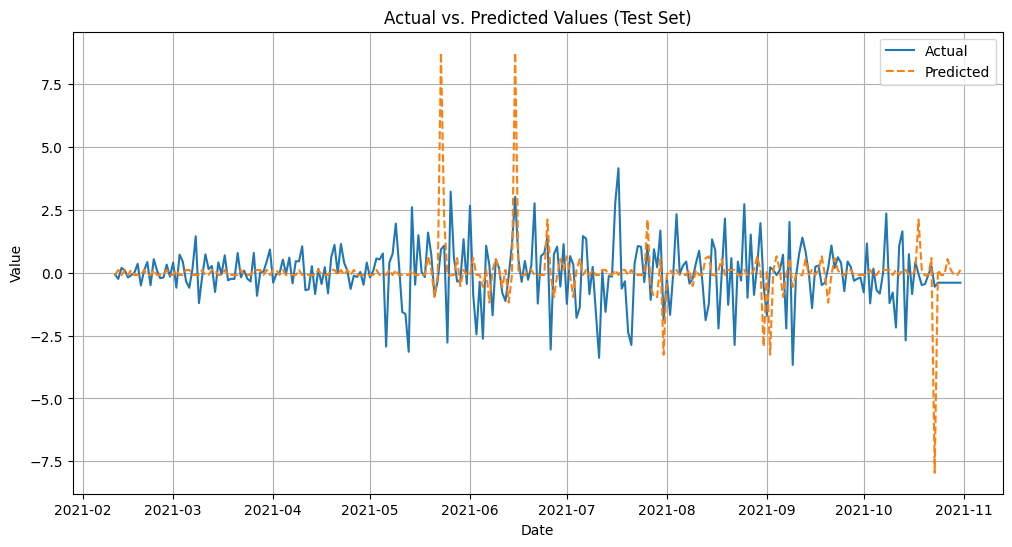

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have forecasted_df_test and pred_df_test DataFrames

# Convert the Spark DataFrames to Pandas for plotting
actual_test_pd = forecasted_df_test.select("Date", "label").toPandas()
predicted_test_pd = pred_df_test.select("Date", "prediction").toPandas()

# Plot the actual vs. predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(actual_test_pd["Date"], actual_test_pd["label"], label="Actual")
plt.plot(predicted_test_pd["Date"], predicted_test_pd["prediction"], label="Predicted", linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Actual vs. Predicted Values (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
forecast_days = 7  # Adjust this value according to your needs
nLags = 7  # Adjust this value for the number of lags you want to include
timeSeriesColumn = "Differenced_t_kWh"  # Use the differenced column created by the Difference function
regressor = "GBTRegression"  # Choose your desired regressor

# Apply the Forecast function
# Assuming you have the differenced column "Differenced_t_kWh" in the "transformed" DataFrame
forecasted_df_test, forecasted_df_train,pred_df_test, pred_df_train, RMSE_test, RMSE_train = Forecast(
    transformed, forecast_days, nLags, "Differenced_t_kWh", regressor, spark
)


# Display or use the results
print("RMSE on Test Data:", RMSE_test)
print("RMSE on Train Data:", RMSE_train)


RMSE on Test Data: 1.42863231758101
RMSE on Train Data: 0.5155679120678526


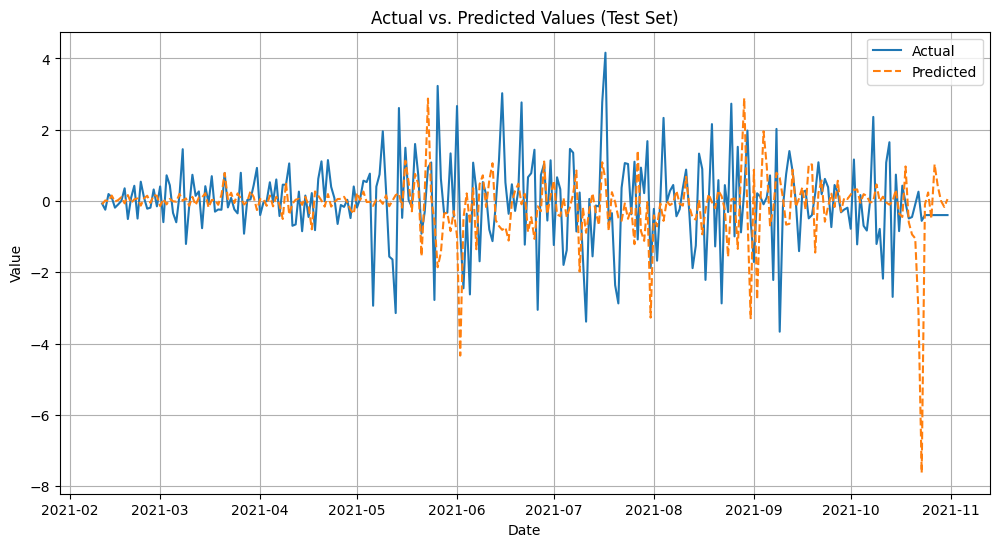

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have forecasted_df_test and pred_df_test DataFrames

# Convert the Spark DataFrames to Pandas for plotting
actual_test_pd = forecasted_df_test.select("Date", "label").toPandas()
predicted_test_pd = pred_df_test.select("Date", "prediction").toPandas()

# Plot the actual vs. predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(actual_test_pd["Date"], actual_test_pd["label"], label="Actual")
plt.plot(predicted_test_pd["Date"], predicted_test_pd["prediction"], label="Predicted", linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Actual vs. Predicted Values (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
forecast_days = 7  # Adjust this value according to your needs
nLags = 7  # Adjust this value for the number of lags you want to include
timeSeriesColumn = "Differenced_t_kWh"  # Use the differenced column created by the Difference function
regressor = "RandomForestRegression"  # Choose your desired regressor

# Apply the Forecast function
# Assuming you have the differenced column "Differenced_t_kWh" in the "transformed" DataFrame
forecasted_df_test, forecasted_df_train,pred_df_test, pred_df_train, RMSE_test, RMSE_train = Forecast(
    transformed, forecast_days, nLags, "Differenced_t_kWh", regressor, spark
)


# Display or use the results
print("RMSE on Test Data:", RMSE_test)
print("RMSE on Train Data:", RMSE_train)


RMSE on Test Data: 1.181930820509268
RMSE on Train Data: 0.9155883191744973


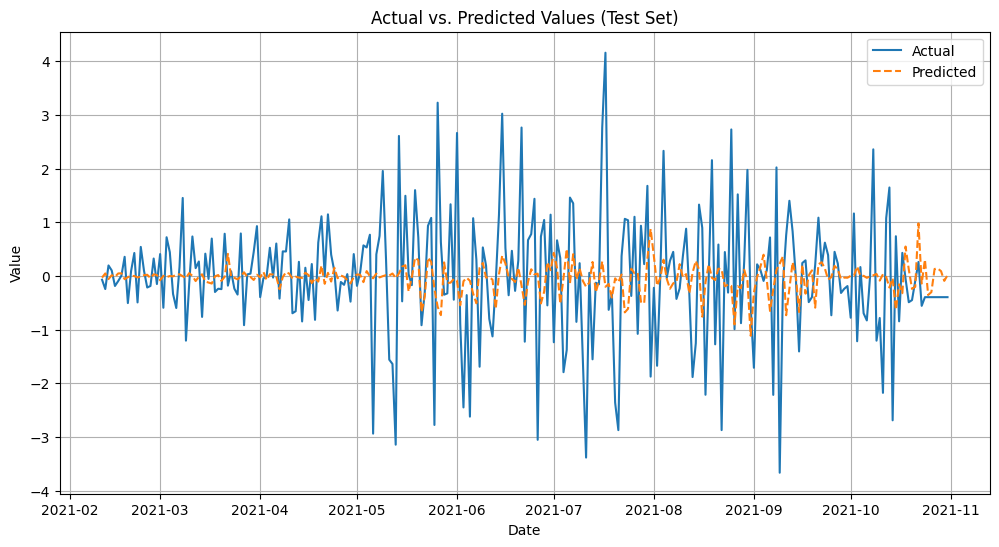

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have forecasted_df_test and pred_df_test DataFrames

# Convert the Spark DataFrames to Pandas for plotting
actual_test_pd = forecasted_df_test.select("Date", "label").toPandas()
predicted_test_pd = pred_df_test.select("Date", "prediction").toPandas()

# Plot the actual vs. predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(actual_test_pd["Date"], actual_test_pd["label"], label="Actual")
plt.plot(predicted_test_pd["Date"], predicted_test_pd["prediction"], label="Predicted", linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Actual vs. Predicted Values (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
forecast_days = 7  # Adjust this value according to your needs
nLags = 7  # Adjust this value for the number of lags you want to include
timeSeriesColumn = "Differenced_t_kWh"  # Use the differenced column created by the Difference function
regressor = "LinearRegression"  # Choose your desired regressor

# Apply the Forecast function
# Assuming you have the differenced column "Differenced_t_kWh" in the "transformed" DataFrame
forecasted_df_test, forecasted_df_train, pred_df_test, pred_df_train, RMSE_test, RMSE_train = Forecast(
    transformed, forecast_days, nLags, "Differenced_t_kWh", regressor, spark
)


# Display or use the results
print("RMSE on Test Data:", RMSE_test)
print("RMSE on Train Data:", RMSE_train)


RMSE on Test Data: 1.151604298595871
RMSE on Train Data: 1.099352588694877


In [ ]:
transformed.show()

+----------+------------------+----+-----+---------+------------------+--------------------+--------------------+---------------------+--------------------+
|      Date|         Avg_t_kWh|Year|Month|DayOfWeek| Avg_t_kWh_LagBy_1|               Trend|         Trend_Slope|Avg_t_kWh_5_MovingAvg|   Differenced_t_kWh|
+----------+------------------+----+-----+---------+------------------+--------------------+--------------------+---------------------+--------------------+
|2019-05-09|11.043999999999995|2019|    5|        5|              NULL|                NULL|                NULL|   11.043999999999995|                 0.0|
|2019-05-10|11.929999999999982|2019|    5|        6|11.043999999999995|  0.8859999999999868|                NULL|   11.486999999999988|  0.8859999999999868|
|2019-05-11|14.496000000000006|2019|    5|        7|11.929999999999982|   2.566000000000024|   1.680000000000037|   12.489999999999995|   2.566000000000024|
|2019-05-12|14.276999999999974|2019|    5|        1|14.496

In [ ]:
forecasted_df_test.show()

+----------+------------------+----+-----+---------+------------------+--------------------+--------------------+---------------------+--------------------+--------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------+----------+
|      Date|         Avg_t_kWh|Year|Month|DayOfWeek| Avg_t_kWh_LagBy_1|               Trend|         Trend_Slope|Avg_t_kWh_5_MovingAvg|   Differenced_t_kWh|               label|Differenced_t_kWh_LagBy_1|Differenced_t_kWh_LagBy_2|Differenced_t_kWh_LagBy_3|Differenced_t_kWh_LagBy_4|Differenced_t_kWh_LagBy_5|Differenced_t_kWh_LagBy_6|Differenced_t_kWh_LagBy_7|            features|Row Number|
+----------+------------------+----+-----+---------+------------------+--------------------+--------------------+---------------------+--------------------+--------------------+-------------------------+-------------

In [ ]:
forecasted_df_train.show()

+----------+------------------+----+-----+---------+------------------+-------------------+--------------------+---------------------+-------------------+--------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------+----------+
|      Date|         Avg_t_kWh|Year|Month|DayOfWeek| Avg_t_kWh_LagBy_1|              Trend|         Trend_Slope|Avg_t_kWh_5_MovingAvg|  Differenced_t_kWh|               label|Differenced_t_kWh_LagBy_1|Differenced_t_kWh_LagBy_2|Differenced_t_kWh_LagBy_3|Differenced_t_kWh_LagBy_4|Differenced_t_kWh_LagBy_5|Differenced_t_kWh_LagBy_6|Differenced_t_kWh_LagBy_7|            features|Row Number|
+----------+------------------+----+-----+---------+------------------+-------------------+--------------------+---------------------+-------------------+--------------------+-------------------------+-------------------

In [ ]:
pred_df_train.show()

+----------+------------------+----+-----+---------+------------------+-------------------+--------------------+---------------------+-------------------+--------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------+----------+--------------------+
|      Date|         Avg_t_kWh|Year|Month|DayOfWeek| Avg_t_kWh_LagBy_1|              Trend|         Trend_Slope|Avg_t_kWh_5_MovingAvg|  Differenced_t_kWh|               label|Differenced_t_kWh_LagBy_1|Differenced_t_kWh_LagBy_2|Differenced_t_kWh_LagBy_3|Differenced_t_kWh_LagBy_4|Differenced_t_kWh_LagBy_5|Differenced_t_kWh_LagBy_6|Differenced_t_kWh_LagBy_7|            features|Row Number|          prediction|
+----------+------------------+----+-----+---------+------------------+-------------------+--------------------+---------------------+-------------------+--------------------+---

In [ ]:
pred_df_test.show()

+----------+------------------+----+-----+---------+------------------+--------------------+--------------------+---------------------+--------------------+--------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------+----------+--------------------+
|      Date|         Avg_t_kWh|Year|Month|DayOfWeek| Avg_t_kWh_LagBy_1|               Trend|         Trend_Slope|Avg_t_kWh_5_MovingAvg|   Differenced_t_kWh|               label|Differenced_t_kWh_LagBy_1|Differenced_t_kWh_LagBy_2|Differenced_t_kWh_LagBy_3|Differenced_t_kWh_LagBy_4|Differenced_t_kWh_LagBy_5|Differenced_t_kWh_LagBy_6|Differenced_t_kWh_LagBy_7|            features|Row Number|          prediction|
+----------+------------------+----+-----+---------+------------------+--------------------+--------------------+---------------------+--------------------+------------------

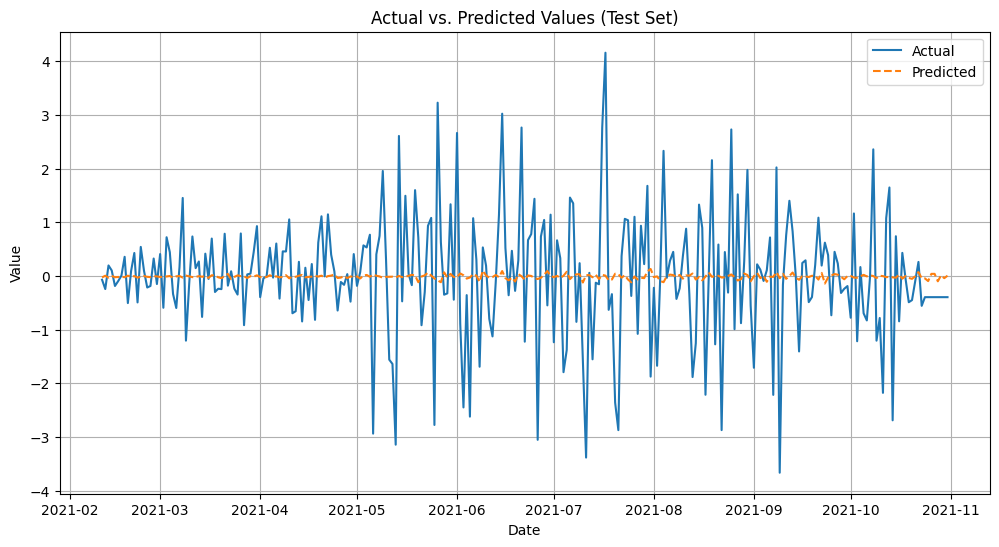

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have forecasted_df_test and pred_df_test DataFrames

# Convert the Spark DataFrames to Pandas for plotting
actual_test_pd = forecasted_df_test.select("Date", "label").toPandas()
predicted_test_pd = pred_df_test.select("Date", "prediction").toPandas()

# Plot the actual vs. predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(actual_test_pd["Date"], actual_test_pd["label"], label="Actual")
plt.plot(predicted_test_pd["Date"], predicted_test_pd["prediction"], label="Predicted", linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Actual vs. Predicted Values (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
forecast_days = 7  # Adjust this value according to your needs
nLags = 7  # Adjust this value for the number of lags you want to include
timeSeriesColumn = "Differenced_t_kWh"  # Use the differenced column created by the Difference function
regressor = "LinearRegressioncross"  # Choose your desired regressor

# Apply the Forecast function
# Assuming you have the differenced column "Differenced_t_kWh" in the "transformed" DataFrame
forecasted_df_test, forecasted_df_train,pred_df_test, pred_df_train, RMSE_test, RMSE_train = Forecast(
    transformed, forecast_days, nLags, "Differenced_t_kWh", regressor, spark
)


# Display or use the results
print("RMSE on Test Data:", RMSE_test)
print("RMSE on Train Data:", RMSE_train)


RMSE on Test Data: 1.1530420484894557
RMSE on Train Data: 1.1021337989204498


In [ ]:
forecast_days = 7  # Adjust this value according to your needs
nLags = 7  # Adjust this value for the number of lags you want to include
timeSeriesColumn = "Differenced_t_kWh"  # Use the differenced column created by the Difference function
regressor = "DecisionTreeRegressioncross"  # Choose your desired regressor

# Apply the Forecast function
# Assuming you have the differenced column "Differenced_t_kWh" in the "transformed" DataFrame
forecasted_df_test, forecasted_df_train,pred_df_test, pred_df_train, RMSE_test, RMSE_train = Forecast(
    transformed, forecast_days, nLags, "Differenced_t_kWh", regressor, spark
)


# Display or use the results
print("RMSE on Test Data:", RMSE_test)
print("RMSE on Train Data:", RMSE_train)


RMSE on Test Data: 1.16878254110583
RMSE on Train Data: 1.077434391958187


In [ ]:
forecast_days = 7  # Adjust this value according to your needs
nLags = 7  # Adjust this value for the number of lags you want to include
timeSeriesColumn = "Differenced_t_kWh"  # Use the differenced column created by the Difference function
regressor = "RandomForestRegressioncross"  # Choose your desired regressor

# Apply the Forecast function
# Assuming you have the differenced column "Differenced_t_kWh" in the "transformed" DataFrame
forecasted_df_test, forecasted_df_train,pred_df_test, pred_df_train, RMSE_test, RMSE_train = Forecast(
    transformed, forecast_days, nLags, "Differenced_t_kWh", regressor, spark
)


# Display or use the results
print("RMSE on Test Data:", RMSE_test)
print("RMSE on Train Data:", RMSE_train)


RMSE on Test Data: 1.171811148862435
RMSE on Train Data: 1.0543635446565696


In [ ]:
forecast_days = 7  # Adjust this value according to your needs
nLags = 7  # Adjust this value for the number of lags you want to include
timeSeriesColumn = "Differenced_t_kWh"  # Use the differenced column created by the Difference function
regressor = "GBTRegressioncross"  # Choose your desired regressor

# Apply the Forecast function
# Assuming you have the differenced column "Differenced_t_kWh" in the "transformed" DataFrame
forecasted_df_test, forecasted_df_train,pred_df_test, pred_df_train, RMSE_test, RMSE_train = Forecast(
    transformed, forecast_days, nLags, "Differenced_t_kWh", regressor, spark
)


# Display or use the results
print("RMSE on Test Data:", RMSE_test)
print("RMSE on Train Data:", RMSE_train)


RMSE on Test Data: 1.272271895185608
RMSE on Train Data: 1.0008563220175848


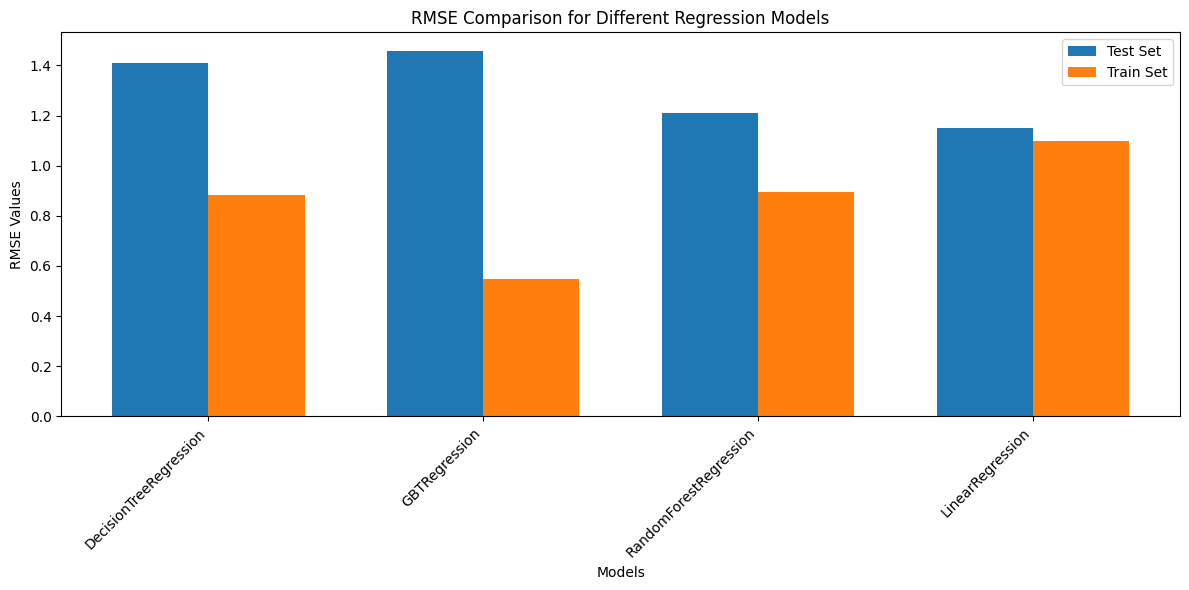

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create dataframes for each regression model
data_rmse = {
    'Model': ['DecisionTreeRegression', 'GBTRegression', 'RandomForestRegression', 'LinearRegression'],
    'RMSE_Test': [1.4117165106081255, 1.4591274762961357, 1.210391301325828, 1.151604298595871],
    'RMSE_Train': [0.883515369464196, 0.5461268144037436, 0.8966095938139512, 1.099352588694877]
}

# Set the bar width and create x-positions for each group
bar_width = 0.35
x = np.arange(len(data_rmse['Model']))

# Plot the RMSE values for Test and Train sets
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width/2, data_rmse['RMSE_Test'], width=bar_width, label='Test Set', align='center')
plt.bar(x + bar_width/2, data_rmse['RMSE_Train'], width=bar_width, label='Train Set', align='center')

plt.xlabel('Models')
plt.ylabel('RMSE Values')
plt.title('RMSE Comparison for Different Regression Models')
plt.xticks(x, data_rmse['Model'], rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()


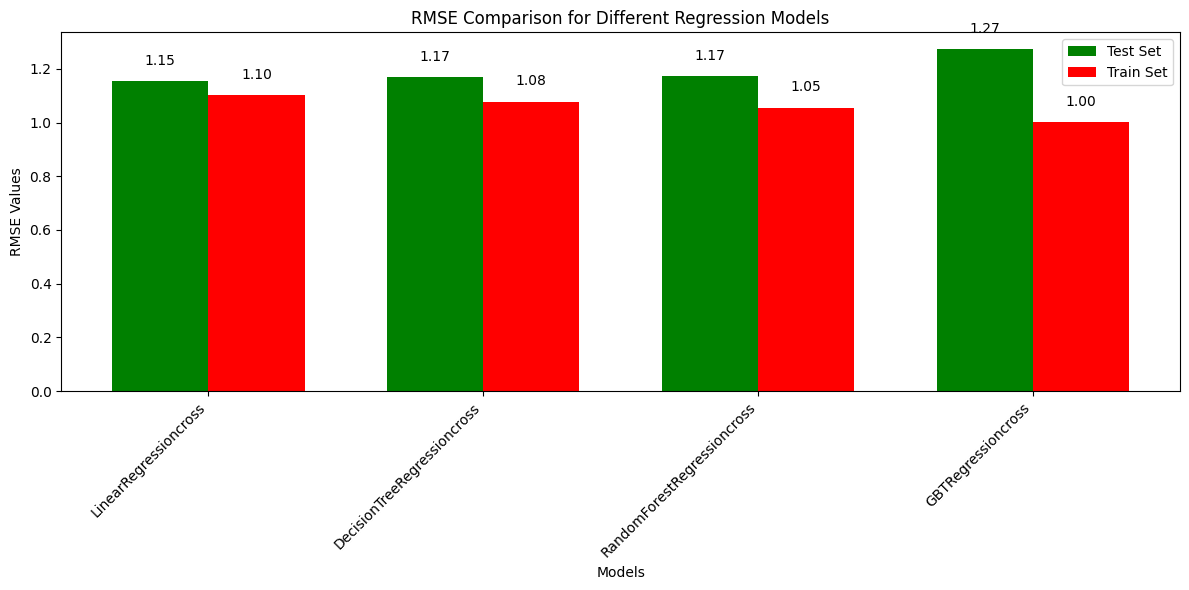

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the RMSE values for each model
data_rmse = {
    'Model': ['LinearRegressioncross', 'DecisionTreeRegressioncross', 'RandomForestRegressioncross', 'GBTRegressioncross'],
    'RMSE_Test': [1.1530420484894557, 1.16878254110583, 1.171811148862435, 1.272271895185608],
    'RMSE_Train': [1.1021337989204498, 1.077434391958187, 1.0543635446565696, 1.0008563220175848]
}

# Set the bar width and create x-positions for each group
bar_width = 0.35
x = np.arange(len(data_rmse['Model']))

# Define colors for Test and Train sets
color_test = 'green'
color_train = 'red'

# Plot the RMSE values for Test and Train sets with the specified colors
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width/2, data_rmse['RMSE_Test'], width=bar_width, label='Test Set', align='center', color=color_test)
plt.bar(x + bar_width/2, data_rmse['RMSE_Train'], width=bar_width, label='Train Set', align='center', color=color_train)

# Add the RMSE values on top of the bars
for i, value in enumerate(data_rmse['RMSE_Test']):
    plt.text(i - bar_width/2, value + 0.05, f'{value:.2f}', ha='center', va='bottom')
for i, value in enumerate(data_rmse['RMSE_Train']):
    plt.text(i + bar_width/2, value + 0.05, f'{value:.2f}', ha='center', va='bottom')

plt.xlabel('Models')
plt.ylabel('RMSE Values')
plt.title('RMSE Comparison for Different Regression Models')
plt.xticks(x, data_rmse['Model'], rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()


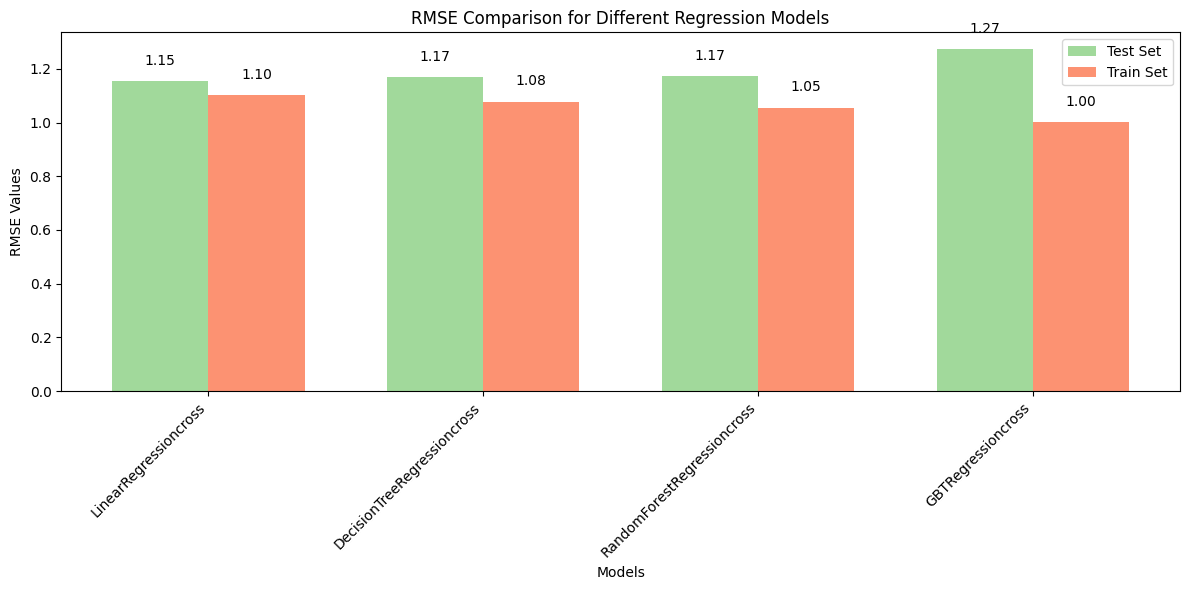

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the RMSE values for each model
data_rmse = {
    'Model': ['LinearRegressioncross', 'DecisionTreeRegressioncross', 'RandomForestRegressioncross', 'GBTRegressioncross'],
    'RMSE_Test': [1.1530420484894557, 1.16878254110583, 1.171811148862435, 1.272271895185608],
    'RMSE_Train': [1.1021337989204498, 1.077434391958187, 1.0543635446565696, 1.0008563220175848]
}

# Set the bar width and create x-positions for each group
bar_width = 0.35
x = np.arange(len(data_rmse['Model']))

# Define lighter colors for Test and Train sets
color_test = '#a1d99b'  # Lighter green
color_train = '#fc9272'  # Lighter red

# Plot the RMSE values for Test and Train sets with the specified colors
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width/2, data_rmse['RMSE_Test'], width=bar_width, label='Test Set', align='center', color=color_test)
plt.bar(x + bar_width/2, data_rmse['RMSE_Train'], width=bar_width, label='Train Set', align='center', color=color_train)

# Add the RMSE values on top of the bars
for i, value in enumerate(data_rmse['RMSE_Test']):
    plt.text(i - bar_width/2, value + 0.05, f'{value:.2f}', ha='center', va='bottom')
for i, value in enumerate(data_rmse['RMSE_Train']):
    plt.text(i + bar_width/2, value + 0.05, f'{value:.2f}', ha='center', va='bottom')

plt.xlabel('Models')
plt.ylabel('RMSE Values')
plt.title('RMSE Comparison for Different Regression Models')
plt.xticks(x, data_rmse['Model'], rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()


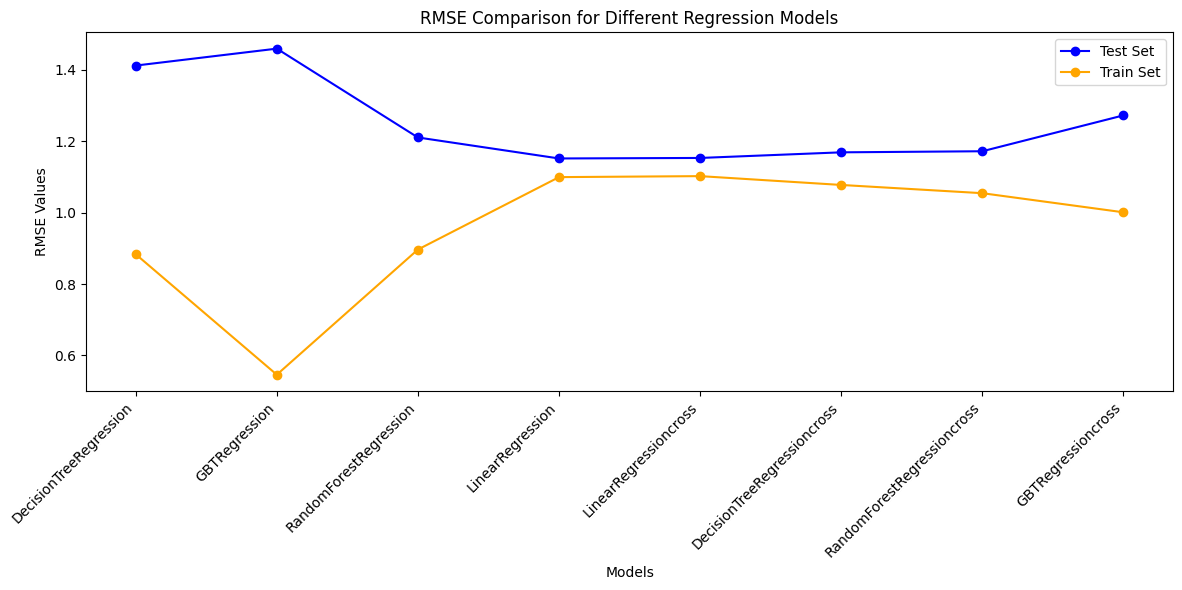

In [ ]:


# Create dataframes for each regression model
data_rmse1 = {
    'Model': ['DecisionTreeRegression', 'GBTRegression', 'RandomForestRegression', 'LinearRegression', 'LinearRegressioncross', 'DecisionTreeRegressioncross', 'RandomForestRegressioncross', 'GBTRegressioncross'],
    'RMSE_Test': [1.4117165106081255, 1.4591274762961357, 1.210391301325828, 1.151604298595871, 1.1530420484894557, 1.16878254110583, 1.171811148862435, 1.272271895185608],
    'RMSE_Train': [0.883515369464196, 0.5461268144037436, 0.8966095938139512, 1.099352588694877, 1.1021337989204498, 1.077434391958187, 1.0543635446565696, 1.0008563220175848]
}

# Set the x-positions for each group
x = range(len(data_rmse1['Model']))

# Plot the RMSE values for Test and Train sets with lines
plt.figure(figsize=(12, 6))
plt.plot(x, data_rmse1['RMSE_Test'], marker='o', linestyle='-', color='blue', label='Test Set')
plt.plot(x, data_rmse1['RMSE_Train'], marker='o', linestyle='-', color='orange', label='Train Set')

plt.xlabel('Models')
plt.ylabel('RMSE Values')
plt.title('RMSE Comparison for Different Regression Models')
plt.xticks(x, data_rmse1['Model'], rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()
